# Fast Slam

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib.animation import FuncAnimation
from util import *

## FastSLAM Algorithm Implementation

This section provides an implementation of the **FastSLAM algorithm**, which combines **particle filtering** for robot trajectory estimation with **Extended Kalman Filters (EKFs)** for landmark estimation. The algorithm follows the **FastSLAM 1.0 framework**, suitable for environments with uniquely identifiable landmarks and Gaussian noise models.

---

### Overview

FastSLAM factorizes the **SLAM posterior**:

$$
p(x_{1:t}, m \mid z_{1:t}, u_{1:t})
= p(x_{1:t} \mid z_{1:t}, u_{1:t}) \prod_i p(m_i \mid x_{1:t}, z_{1:t})
$$

where:
- $x_{1:t}$: robot trajectory up to time $t$  
- $m$: map of landmarks  
- $z_{1:t}$: sensor measurements  
- $u_{1:t}$: control inputs (odometry)  

This separation allows:
1. A **particle filter** to represent possible robot trajectories.  
2. Independent **EKFs** (one per landmark) to estimate feature positions.  

---

### Modeling Assumptions

- **Motion model**: Odometry provides control input; motion noise is Gaussian.  
- **Measurement model**: Each landmark provides range and bearing; noise is Gaussian.  
- **Landmark correspondence**: Each detected landmark can be associated with its signature.  
- **Map representation**: Each particle carries its own map hypothesis.  

---

### Algorithm Steps

1. **Prediction (Odometry Update)**  
   Each particle’s pose is updated according to the odometry model:
   $$
   x_t = f(x_{t-1}, u_t) + \mathcal{N}(0, R)
   $$

2. **Correction (Sensor Update)**  
   For each detected landmark:
   - If landmark is **new**: initialize with observation.  
   - If landmark **exists**:  
     - Compute expected observation $z_\text{hat}$ using:
       $$
       r = \sqrt{(x_l - x)^2 + (y_l - y)^2}, \quad
       \phi = \arctan2(y_l - y, x_l - x) - \theta
       $$
     - Compute innovation $dz = z - z_\text{hat}$.  
     - Apply EKF update with Jacobian $H$:  
       $$
       K = \Sigma H^T (H \Sigma H^T + Q)^{-1}
       $$
       $$
       \mu = \mu + K dz, \quad
       \Sigma = (I - KH)\Sigma
       $$
     - Update particle weight according to measurement likelihood:
       $$
       w \propto \exp\left(-\tfrac{1}{2} dz^T \Psi^{-1} dz \right)
       $$

3. **Resampling**  
   Particles are resampled proportional to their weights to avoid degeneracy.  

4. **Best Estimate**  
   The particle with the highest weight is selected as the **fittest particle**, representing the current best guess of robot pose and map.  

---

### Additional Features in the Code

- **discardDubiousFeatures**: Removes landmarks with low credibility, mitigating false detections.  
- **draw**: Allows visualization of the map and trajectory of the fittest particle.  
- **update cycle**: Encapsulates the full SLAM iteration (odometry update → sensor update → best particle update → resampling).  



## Initialize Map

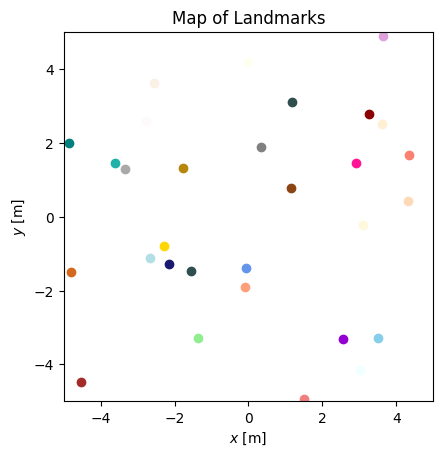

In [2]:
# create map
n_landmarks = 30

x_roi = (-5, 5)
y_roi = (-5, 5)

roi = (x_roi, y_roi)

landmarks = []
for signature in range(n_landmarks):
    landmarks.append(Landmark(Pose.random(roi), signature))

# landmarks.append(Landmark(Pose(2, 0, Angle(0)), 0))
# landmarks.append(Landmark(Pose(3, -1, Angle(30)), 1))
# landmarks.append(Landmark(Pose(3, 1, Angle(-30)), 2))

landmark_map = ParticleMap(landmarks, roi)

#plot map
f, ax = plt.subplots()

ax.set_xlim(x_roi)
ax.set_ylim(y_roi)
ax.set_title("Map of Landmarks")
ax.set_xlabel("$x$ [m]")
ax.set_ylabel("$y$ [m]")
ax.set_aspect('equal', adjustable='box')

landmark_map.draw(ax)

## Initialize the Robot and Sensor

In [3]:
#robot's initial position
robot_pose  = Pose(0, 0, Angle(0))
sensor_pose = Pose(0.5, 0, Angle(0))
th_fov = Angle(60) #[°]
sensor_range = 5 #[m]

#define robot's sensor
sensors = [
    CameraSensor(sensor_pose, th_fov, robot_pose=robot_pose, range=sensor_range)
]

robot = Robot(robot_pose, sensors, landmark_map)

# Aux funcs for init and reset at block begin
def resetRobot():
    robot.updatePosition(robot_pose)

def initializeSLAM():    
    return FastSlam(50, landmark_map.roi, init_pose=robot.pos)

## Initialize the sample Control Input

In [7]:
dt  = 1 #[s]
th1 = Angle(10) #[°]
th2 = Angle(45) #[°]
d   = 0.7 #[m]

u = Odometry(th1, d, th2, dt)

## Step-by-Step SLAM Update Visualization

This code creates a **2×2 figure** to illustrate the progression of robot motion and SLAM updates:

1. **AX1 – Initial Position**  
   - Shows the robot’s starting position on the map.  
   - Landmarks are drawn for reference.  

2. **AX2 – Motion Command**  
   - Demonstrates the effect of applying a control input $u$.  
   - The **dashed pose** shows the *expected position* (without motion noise).  
   - The **solid pose** shows the *actual position* after applying noisy odometry.

3. **AX3 – SLAM Odometry Update**
   - Updates all SLAM particles with the odometry model.  
   - Displays the cloud of particles representing different hypotheses of the robot’s pose in absolute coordinates.

4. **AX4 – SLAM Measurement Update**  
   - The robot senses landmarks with noisy sensor readings.  
   - SLAM updates the particle maps using the sensor model and resampling.  
   - The fittest particle’s map is shown, shifted to the robot’s position for comparison.  
   - Sensor observations (lines to landmarks) are drawn, demonstrating how features are incorporated.  
   - The estimated position distribution of each detected landmark is shown (uncertainty ellipses).  



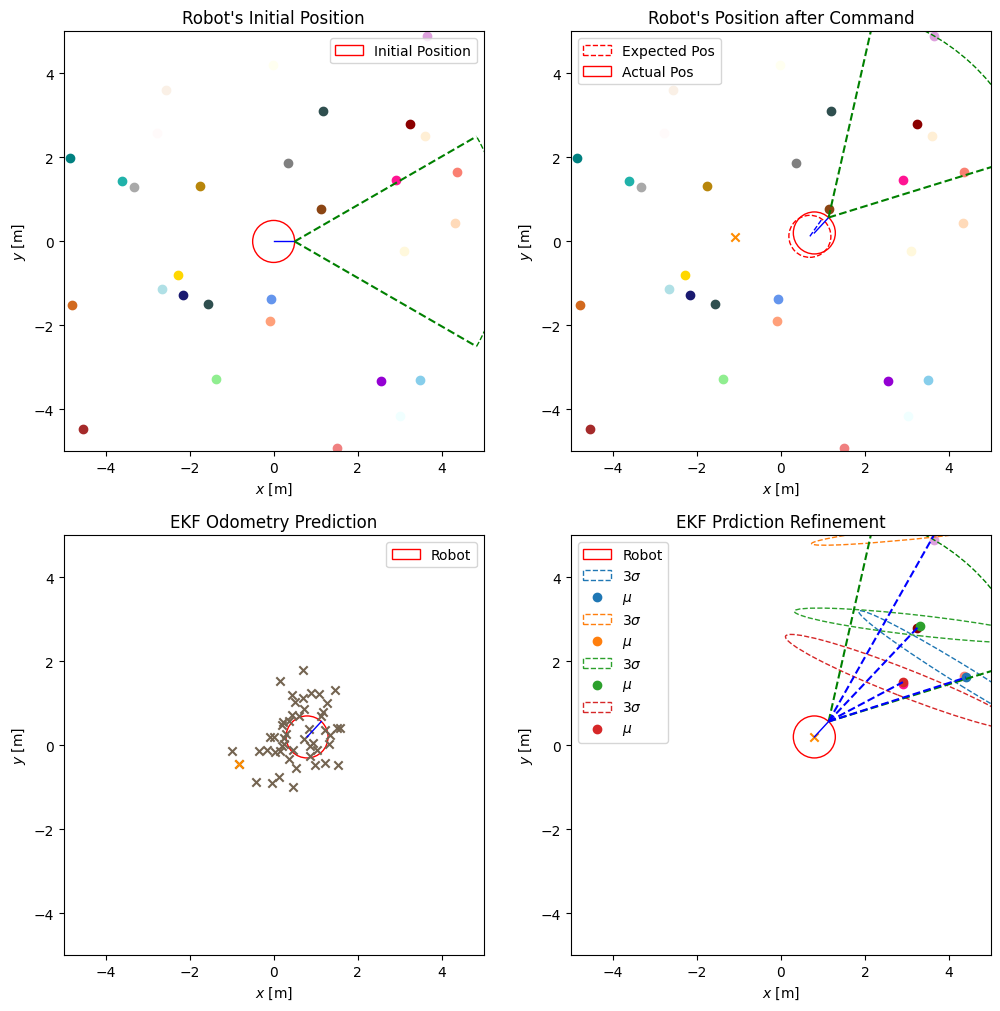

In [ ]:
resetRobot()
slam = initializeSLAM()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
### --- AX1
ax1.set_title("Robot's Initial Position")
ax1.set_xlim(x_roi)
ax1.set_ylim(y_roi)
ax1.set_xlabel("$x$ [m]")
ax1.set_ylabel("$y$ [m]")

landmark_map.draw(ax1)
robot.draw(ax1, label="Initial Position")
# slam.draw(ax1, n_sigmas=1)

### --- AX2
ax2.set_title("Robot's Position after Command")
ax2.set_xlim(x_roi)
ax2.set_ylim(y_roi)
ax2.set_xlabel("$x$ [m]")
ax2.set_ylabel("$y$ [m]")

landmark_map.draw(ax2)

robot.applyControl(u, motion_noise=False)
robot.draw(ax2, label="Expected Pos", linestyle='--', draw_sensor=False)

resetRobot()

robot.applyControl(u)
robot.draw(ax2, label="Actual Pos")
### --- AX3
ax3.set_title("SLAM Odometry Update")
ax3.set_xlim(x_roi)
ax3.set_ylim(y_roi)
ax3.set_xlabel("$x$ [m]")
ax3.set_ylabel("$y$ [m]")

slam.updateFromOdometry(u)
robot.draw(ax3, label="Robot", draw_sensor=False)
slam.draw(ax3, n_sigmas=1, draw_all_particles=True)

### --- AX4
ax4.set_title("SLAM Measurement Update")
ax4.set_xlim(x_roi)
ax4.set_ylim(y_roi)
ax4.set_xlabel("$x$ [m]")
ax4.set_ylabel("$y$ [m]")

sensor_readings = robot.getSensorReadings(detection_noise=True, std_meas_noise=0.1) 
deteced_features = sensor_readings[0][0]
correspondences = sensor_readings[0][1]

slam.updateFromSensorModel(deteced_features)
slam.resampleParticles()
slam.updateFittestParticel()
# ekf.predictKnownCorrespondence(deteced_features, correspondences)

landmark_map.draw(ax4, correspondences)
robot.draw(ax4, label="Robot", draw_sensor_readings=True)
slam.draw(ax4, n_sigmas=3, draw_all_sigma=False, shift_to=robot.pos)


## Visualizing SLAM with Relative Maps

In this experiment, the robot follows a randomly generated velocity trajectory.  
The SLAM algorithm incrementally estimates both the robot’s pose and the positions of landmarks based on sensor readings.

---

### Relative Nature of the SLAM Map
It is important to note that the SLAM algorithm produces a **map relative to the robot’s estimated trajectory**, not the absolute ground-truth coordinates.  
This happens because:
- The robot starts without an absolute reference frame.  
- Motion and sensor noise accumulate, causing drift in the global frame.  
- As a result, the map may appear rotated or translated compared to the real environment.  

However, the **relative positions** between landmarks and the robot are preserved.

---

### Shifting for Visualization
In the visualization below, we **shift the SLAM map** so that the robot’s estimated position aligns with its actual position in the true map.  

This alignment allows us to:
- Directly compare the **relative geometry** of the estimated landmarks with the real landmarks.  
- Visually check if the estimated map overlays the true map once the robot is aligned.  
- Assess accuracy: the closer the overlaid maps are, the more consistent the SLAM estimate is with reality.  

---

The animation shows this process:  
- The left plot displays the **ground-truth map of landmarks** with the SLAM map shifted to the robot’s real pose for easier comparison.
- The right plot shows the **robot’s actual position** and the **measured landmarks**. 

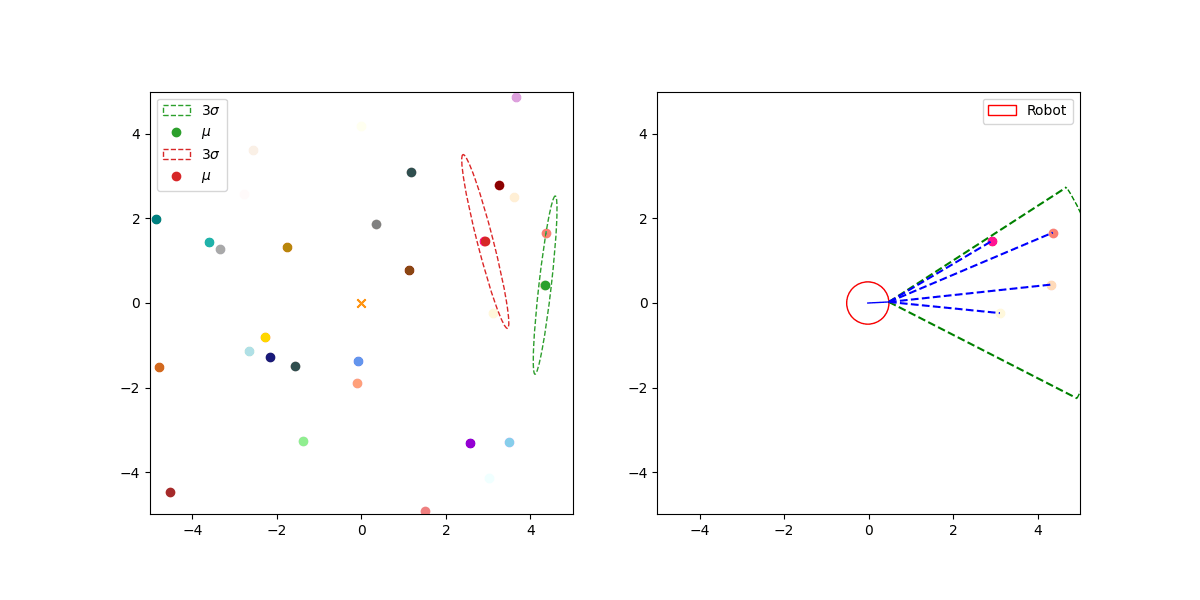

In [6]:
resetRobot()
slam = initializeSLAM()

dt = 0.05
animation_time = 5 #[s]

n_frames = int(animation_time / dt)
trajectory = generateRandomVelocityTrajectory(n_frames,dt)
applied_controls = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_aspect('equal', adjustable='box')
ax1.set_title("Map of Landmarks")
ax1.set_xlabel("$x$ [m]")
ax1.set_ylabel("$y$ [m]")
ax2.set_title("Robot's State Estimation")
ax2.set_xlabel("$x$ [m]")
ax2.set_ylabel("$y$ [m]")
#update function for animation
def update(frame):
    global applied_controls
    ax2.clear()
    ax1.clear()

    u = trajectory[frame]

    applied_controls.append(robot.applyControl(u, motion_noise=False))

    sensor_readings = robot.getSensorReadings(detection_noise=False, std_meas_noise=0.1) 
    deteced_features = sensor_readings[0][0]
    correspondences = sensor_readings[0][1]

    slam.update(u, deteced_features)

    ax1.set_xlim(x_roi)
    ax1.set_ylim(y_roi)

    ax2.set_xlim(x_roi)
    ax2.set_ylim(y_roi)

    landmark_map.draw(ax2, correspondences=correspondences)
    robot.draw(ax2, label = "Robot", draw_sensor_readings=True)
    
    landmark_map.draw(ax1)
    slam.draw(ax1, shift_to=robot.pos)

ani = FuncAnimation(fig, update, frames=np.arange(0, n_frames), interval=50)

gif_path = 'img/7/knownCorr.gif'
ani.save(gif_path, writer='pillow', fps=20)

plt.close(fig)

display(Image(filename=gif_path))